In [1]:
import time, os, math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def LAPLACIAN_JACOBI(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx):
    return 0.25*(phi_old[neighbor_r[idx]]+phi_old[neighbor_l[idx]]+phi_old[neighbor_u[idx]]+phi_old[neighbor_d[idx]]\
                 -dx**2*source[idx])
    
def LAPLACIAN_GAUSS_SEIDEL(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] = 0.25*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]\
                              +phi_old[neighbor_u[idx_even]]+phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even])
    phi_old[idx_odd] = 0.25*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]\
                             +phi_old[neighbor_u[idx_odd]]+phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd])
    return phi_old

def LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi_old, omega, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] += 0.25*omega*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]+phi_old[neighbor_u[idx_even]]\
                                     +phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even]-4.*phi_old[idx_even])
    phi_old[idx_odd] += 0.25*omega*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]+phi_old[neighbor_u[idx_odd]]\
                                     +phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd]-4.*phi_old[idx_odd])
    return phi_old
    
def CALCULATE_CRITERIA(phi, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d):
    diff = ((phi[neighbor_r]+phi[neighbor_l]+phi[neighbor_u]+phi[neighbor_d]-4.*phi)-dx**2*source)[boundary==False]
    return (diff**2).mean()

def CHECKER_BOARD(N):
    A = np.arange(N*N//2)
    X = (2*A)%N
    Y = (2*A)//N
    P = (X+Y+1)%2
    X += P
    ODD_INDEX = (X + Y*N).copy()
    ODD_INDEX = ODD_INDEX[((ODD_INDEX//N!=N-1)&(ODD_INDEX//N!=0)&(ODD_INDEX%N!=N-1)&(ODD_INDEX%N!=0))]
    
    X = (2*A)%N
    Y = (2*A)//N
    P = (X+Y)%2
    X += P
    EVEN_INDEX = (X + Y*N).copy()
    EVEN_INDEX = EVEN_INDEX[((EVEN_INDEX//N!=N-1)&(EVEN_INDEX//N!=0)&(EVEN_INDEX%N!=N-1)&(EVEN_INDEX%N!=0))]
    return EVEN_INDEX, ODD_INDEX

In [12]:
data_CG = np.loadtxt("./simulated_field_distribution_GPU_CG.txt")
data_analytic = np.loadtxt("./analytical_field_distribution_CG.txt")

In [3]:
L = 1.0
N = 128
dx = dx = L/(N-1)
x = np.arange(0,N)
y = np.arange(0,N)
xx,yy= np.meshgrid(x,y)

phi_analytic = np.exp(dx*xx-dx*yy)*dx*xx*(1.-dx*xx)*dx*yy*(1.-dx*yy)
rho = (2*dx*xx*(dx*yy-1.)*(dx*yy-2.*dx*xx+dx*xx*dx*yy+2.)*np.exp(dx*xx-dx*yy)).ravel()
# phi_analytic = (1.0-yy)

phi = np.zeros(N*N)

boundary = ((yy%N==0) | (yy%N==N-1) | (xx%N==0) | (xx%N==N-1)).ravel()
phi[boundary] = phi_analytic.ravel()[boundary]
iteration = 0
iteration_max = 4000000
show_error_interval = 100
# mode = 'jacobi'
# mode = 'gauss_seidel'
mode = 'SOR'

neighbor_r = np.arange(N*N)
neighbor_l = np.arange(N*N)
neighbor_u = np.arange(N*N)
neighbor_d = np.arange(N*N)
neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

# criteria = CALCULATE_CRITERIA(phi_analytic.ravel(), rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
criteria = 1e-21
error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
rho[boundary] = 0.0

In [6]:
phi_analytic, phi.reshape(N,N)

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.52583197e-05, 3.05159312e-05, ...,
         8.16598630e-05, 4.11523805e-05, 0.00000000e+00],
        [0.00000000e+00, 3.02775267e-05, 6.05536480e-05, ...,
         1.62040036e-04, 8.16598630e-05, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.13145784e-05, 2.26286316e-05, ...,
         6.05536480e-05, 3.05159312e-05, 0.00000000e+00],
        [0.00000000e+00, 5.65742051e-06, 1.13145784e-05, ...,
         3.02775267e-05, 1.52583197e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [169]:
rho_data = np.loadtxt("./charge_distribution_CG.txt")

KeyboardInterrupt: 

In [170]:
rho.reshape(N,N), rho_data

(array([[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.79012346, -1.51622091,  0.        ],
        [ 0.        , -0.35384262, -0.79012346,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 array([[-0.        , -1.24054438, -1.73131915, -0.        ],
        [-0.        , -0.79012346, -1.51622091, -1.73131915],
        [-0.        , -0.35384262, -0.79012346, -1.24054438],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]))

In [171]:
error**0.5

0.10646857462576419

In [172]:
(((phi[neighbor_r]+phi[neighbor_l]+phi[neighbor_u]+phi[neighbor_d]-4.*phi)/dx**2-rho)**2).reshape(N,N)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.62429508, 2.29892584, 0.        ],
       [0.        , 0.1252046 , 0.62429508, 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [4]:
photon_mass = 1e-4

In [5]:
A = np.zeros((N*N,N*N))
for j in range(1,N-1):
    for i in range(1,N-1):
        A[i+j*N,i-1+j*N] = 1.
        A[i+j*N,i+1+j*N] = 1.
        A[i+j*N,i+(j-1)*N] = 1.
        A[i+j*N,i+(j+1)*N] = 1.
        A[i+j*N,i+j*N] = -4.+(photon_mass*dx)**2

In [6]:
indices = np.arange(N*N).reshape(N,N)[1:N-1,1:N-1].ravel()
A_inv = np.linalg.inv(A[indices][:,indices])
A_inv.max()

-1.4456949142105621e-08

In [7]:
A_inv.max()*A.max()

-1.4456949142105621e-08

In [92]:
(np.dot(A_p,A_p)/(N-2)**2)**0.5

0.003938344273339069

In [129]:
(np.dot(rho*dx**2,rho*dx**2)/(N-2)**2)**0.5

0.020070841597650116

In [124]:
rho.reshape(N,N)

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.79012346, -1.51622091,  0.        ],
       [ 0.        , -0.35384262, -0.79012346,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [138]:
data_field_analytic = np.loadtxt("./analytical_field_distribution_CG.txt")
data_field_simulatd = np.loadtxt("./simulated_field_distribution_GPU_CG.txt")
# data_rho = np.loadtxt("./charge_distribution.txt")
N = data_field_simulatd.shape[0]
L = 1.0
dx = L/N
xx, yy = np.meshgrid(np.arange(N), np.arange(N))

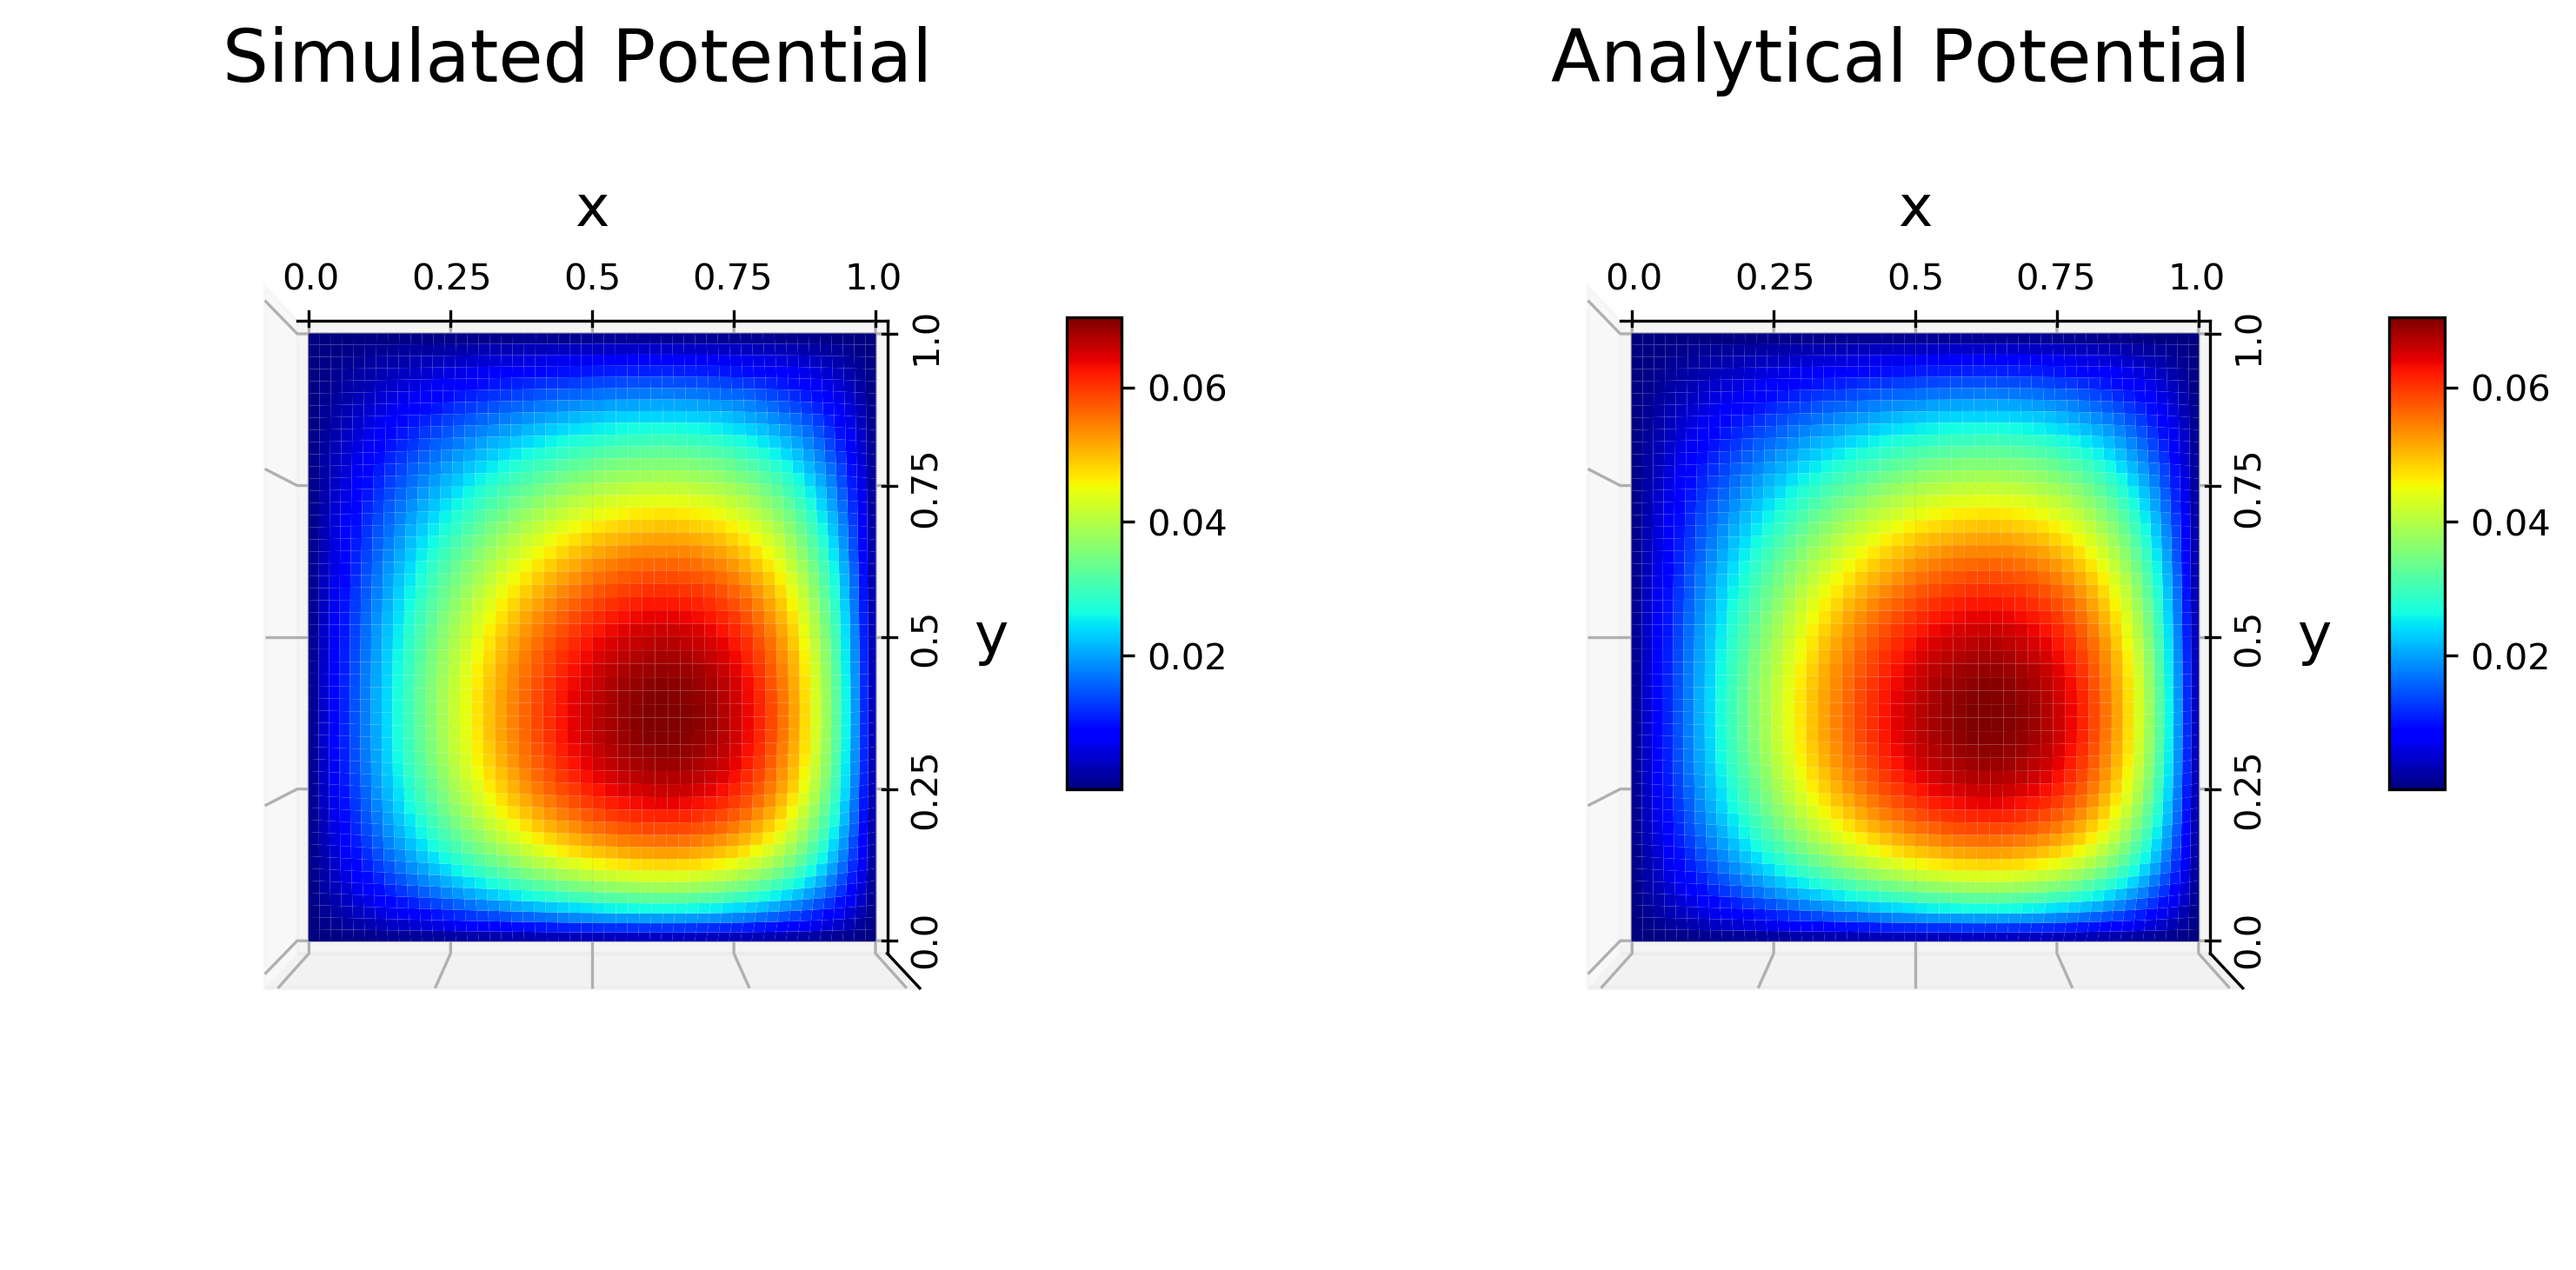

In [139]:
fig = plt.figure(figsize=(2*6,6), dpi=300)

ax_1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax_1.plot_surface(dx*xx, dx*yy, data_field_simulatd, cmap='jet', edgecolor='none', )
ax_1.set_title('Simulated Potential', fontsize=20, y=1.05)
ax_1.view_init(90,-90)
ax_1.axis('tight')
ax_1.set_xlim([0,L])
ax_1.set_ylim([0,L])
ax_1.set_xticks(np.linspace(0,L,5))
ax_1.set_yticks(np.linspace(0,L,5))
ax_1.set_xticklabels(np.linspace(0,L,5), fontsize=10., va='center')
ax_1.set_yticklabels(np.linspace(0,L,5), fontsize=10., va='center', rotation=90)
ax_1.set_zticks([])
ax_1.set_xlabel('x', labelpad=10, fontsize=16)
ax_1.set_ylabel('y', labelpad=10, fontsize=16)
axins_1 = inset_axes(ax_1,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.01, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_1.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_1)

ax_2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax_2.plot_surface(dx*xx, dx*yy, data_field_analytic, cmap='jet', edgecolor='none', )
ax_2.set_title('Analytical Potential', fontsize=20, y=1.05)
ax_2.view_init(90,-90)
ax_2.axis('tight')
ax_2.set_xlim([0,L])
ax_2.set_ylim([0,L])
ax_2.set_xticks(np.linspace(0,L,5))
ax_2.set_yticks(np.linspace(0,L,5))
ax_2.set_xticklabels(np.linspace(0,L,5), fontsize=10., va='center')
ax_2.set_yticklabels(np.linspace(0,L,5), fontsize=10., va='center', rotation=90)
ax_2.set_zticks([])
ax_2.set_xlabel('x', labelpad=10, fontsize=16.)
ax_2.set_ylabel('y', labelpad=10, fontsize=16.)
axins_2 = inset_axes(ax_2,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.01, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_2.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_2)
# plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW6/Simulated_v.s._Analytic_Potential_N=512_Criteria=1.00000000e-10.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
plt.show()

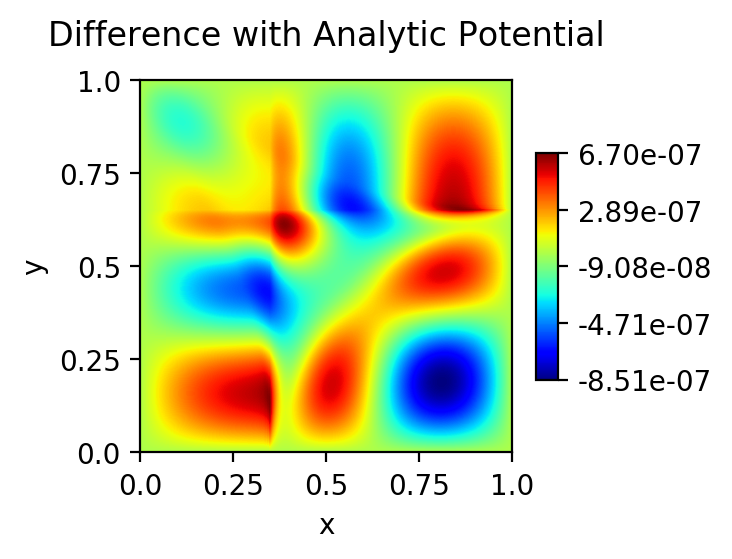

In [140]:
difference = data_field_simulatd-data_field_analytic
ticks=np.linspace(difference.min(), difference.max(),5)

fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.imshow(difference[::-1,:], cmap='jet') # flip the phi to consistent with the figures above
plt.title("Difference with Analytic Potential", y=1.05)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.linspace(0,N,5), np.linspace(0,L,5))
plt.yticks(np.linspace(0,N,5), np.flip(np.linspace(0,L,5))) # flip the y axis
fig.colorbar(ax, shrink=0.5, aspect=10, ticks=ticks, format='%.2e')
# plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW6/Simulated_v.s._Analytic_Potential_Difference_N=512_Criteria=1.00000000e-10.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
plt.show()